## Observation
Model performance degrades non-linearly with increasing weight perturbations.
Small perturbations have limited impact, while larger perturbations cause rapid loss of accuracy.


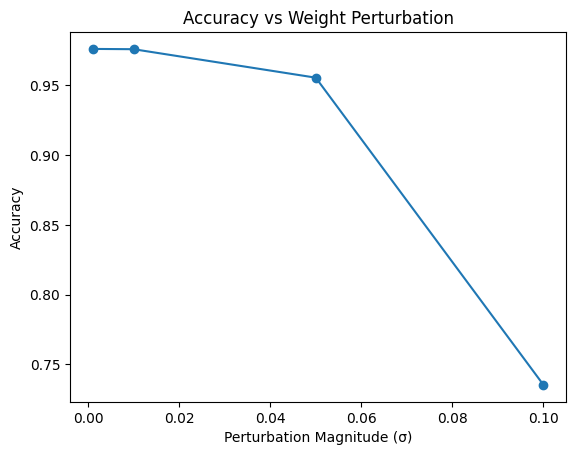

In [2]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model definition (same as before)
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 10)
        )

    def forward(self, x):
        return self.net(x)

model = MLP().to(device)
model.load_state_dict(torch.load("../baseline_model.pth"))
model.eval()

criterion = nn.CrossEntropyLoss()

# Test data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

test_dataset = datasets.MNIST(
    root="./data", train=False, download=True, transform=transform
)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1000)

# Evaluation function
def evaluate(model):
    model.eval()
    total_loss = 0
    correct = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            total_loss += criterion(output, target).item()
            pred = output.argmax(dim=1)
            correct += pred.eq(target).sum().item()

    avg_loss = total_loss / len(test_loader)
    accuracy = correct / len(test_dataset)
    return avg_loss, accuracy

# Baseline
base_loss, base_acc = evaluate(model)

sigmas = [0.001, 0.01, 0.05, 0.1]
losses = []
accuracies = []

for sigma in sigmas:
    perturbed_model = MLP().to(device)
    perturbed_model.load_state_dict(model.state_dict())

    with torch.no_grad():
        for param in perturbed_model.parameters():
            noise = torch.randn_like(param) * sigma
            param.add_(noise)

    loss, acc = evaluate(perturbed_model)
    losses.append(loss)
    accuracies.append(acc)

# Plot results
plt.figure()
plt.plot(sigmas, accuracies, marker='o')
plt.xlabel("Perturbation Magnitude (σ)")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Weight Perturbation")
plt.show()
